In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import pycountry
import re

from tqdm.notebook import tqdm
tqdm.pandas()

from cdifflib import CSequenceMatcher

from collections import Counter
import nltk

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
train = pd.read_csv('data/train.csv', index_col='pair_id')
test = pd.read_csv('data/test.csv', index_col='pair_id')

In [3]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
0,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
1,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
2,Tress A/S,Longyou Industries Park Zhejiang,0
3,Wpt Mexico Sa De Cv,Hopkins Mfg. De Mexico S De Rl De Cv,0
4,National Bank Of,Action International,0


## Dataset Initial EDA

In [4]:
train.is_duplicate.value_counts()

0    455742
1      3708
Name: is_duplicate, dtype: int64

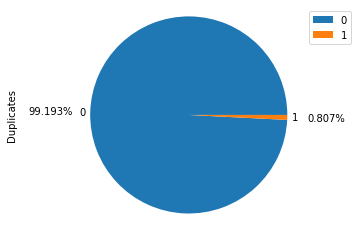

In [5]:
train.is_duplicate.value_counts().plot(kind='pie', label='Duplicates',
                                       autopct='%.3f%%', pctdistance=1.4, labeldistance=1.05)
plt.legend()
plt.axis('equal')
plt.show()

Data in train dataset is too imbalanced, thus it is necessary to either use weighted loss functions, to do over(under)sampling or use NLP data augmentation techniques

In [6]:
simmilar = train[train.is_duplicate==1]
diff = train[train.is_duplicate==1]

In [7]:
simmilar

,name_1,name_2,is_duplicate
pair_id,,,
144,JX Nippon Oil & Gas Exploration (Brasil) Ltda,JX Nippon Oil & Gas Exploration Technical Serv...,1
560,Pirelli Neumaticos S.A.I.C.,"Pirelli Tyre Co., Ltd.",1
774,Brenntag Australia (Pty) Ltd.,Brenntag Group,1
1230,"PAUL BAUDER GMBH & CO KG, BOCHUM PLANT",Paul Bauder ag,1
1445,TOTAL CESKA REPUBLIKA s.r.o.,TOTAL FRANCE (ARNAY LE DUC),1
...,...,...,...
458469,Arlanxeo International Group,Arlanxeo Corp.,1
458706,Brenntag Peru S.A.C.,Brenntag Chile Comercial E Industrial Ltda,1
458769,Dow Chemical International Private Ltd.,Dow Chemical Pacific,1


Let us look at top of frequent words in our test dataset, we're seeing mostly legal entities, stopwords, or excess words without any additional information to string duplicate classification algorithms

               Frequency
Word                    
ltd.               58732
co.,               24985
international      21088
inc.               21041
de                 19397
industries         14423
trading            12014
logistics          11142
&                  10933
rubber              8540


<AxesSubplot:xlabel='Word'>

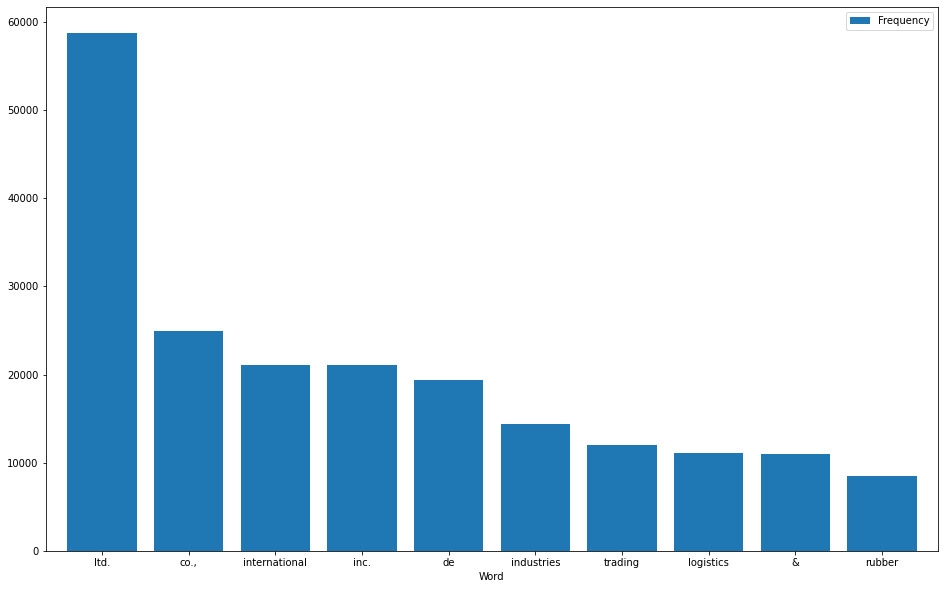

In [8]:
top_N = 10

stopwords = nltk.corpus.stopwords.words('english')

RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))

words = (test.name_1
           .str.lower()
           .replace([r'\|', RE_stopwords], [' ', ''], regex=True)
           .str.cat(sep=' ')
           .split()
)

# generate DF out of Counter
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
print(rslt)

# plot
rslt.plot.bar(rot=0, figsize=(16,10), width=0.8)

## Possible ideas for improving baseline

- thorough data cleaning and preprocessing
- balance classes, weighted loss function, oversampling, undersampling
- text data augmentation
- tfidf, countvectorizer, doc2vec, word2vec
- add another similarity metrics: levenshtein, jaccard, jaro winkler, n-gram, etc


- binary feature: whether one title contains all the words of another
- numeric feature: the number of matching first vowels, consonants
- numeric feature: the number of matching first letters of the abbreviation
- numeric feature: percentage of intersecting ngrams
- numeric feature: the number of matching first letters of each word (take the maximum)
- numeric feature: number of letters of the first, number of letters of the second
- numeric feature: the number of words of the first, the number of the second


## Data Cleaning

#### 1. Strings to lowercase

In [9]:
train.name_1 = train.name_1.str.lower()
train.name_2 = train.name_2.str.lower()
train.name_1 = train.name_1.str.strip()
train.name_2 = train.name_2.str.strip()

test.name_1 = test.name_1.str.lower()
test.name_2 = test.name_2.str.lower()
test.name_1 = test.name_1.str.strip()
test.name_2 = test.name_2.str.strip()

In [10]:
train[train.is_duplicate==1].head()

,name_1,name_2,is_duplicate
pair_id,,,
144,jx nippon oil & gas exploration (brasil) ltda,jx nippon oil & gas exploration technical serv...,1
560,pirelli neumaticos s.a.i.c.,"pirelli tyre co., ltd.",1
774,brenntag australia (pty) ltd.,brenntag group,1
1230,"paul bauder gmbh & co kg, bochum plant",paul bauder ag,1
1445,total ceska republika s.r.o.,total france (arnay le duc),1


#### 2. Remove country names from strings (excess information)

In [11]:
%%time

countries = [country.name.lower() for country in pycountry.countries]

for country in tqdm(countries):
    train.replace(re.compile(country), "", inplace=True)
    test.replace(re.compile(country), "", inplace=True)

  0%|          | 0/249 [00:00<?, ?it/s]

CPU times: user 5min 18s, sys: 103 ms, total: 5min 18s
Wall time: 5min 18s


In [12]:
train[train.is_duplicate==1].head()

,name_1,name_2,is_duplicate
pair_id,,,
144,jx nippon oil & gas exploration (brasil) ltda,jx nippon oil & gas exploration technical serv...,1
560,pirelli neumaticos s.a.i.c.,"pirelli tyre co., ltd.",1
774,brenntag (pty) ltd.,brenntag group,1
1230,"paul bauder gmbh & co kg, bochum plant",paul bauder ag,1
1445,total ceska republika s.r.o.,total (arnay le duc),1


#### 3. Remove countries, cities, location entitites from strings

In [13]:
filter_words = ['international', 'brasil', 'usa', 'ceska republika', 'czech republic', 'polska', 'venezuela',
               'shanghai', 'shenzhen', 'qingdao', 'dongguan', 'guangzhou',
               'america', 'rumunia', 'италия', 'toronto', 'mexicana','nederland', 'us.', 'texas', 
               'vietnam', 'houston', 'asia', 'africa', 'americas', 'new york',
               'korea', 'deutschland', 'pacific', 'north', 'south', 'west', 'east']

In [14]:
for word in tqdm(filter_words):
    train.replace(re.compile(word), "", inplace=True)
    test.replace(re.compile(word), "", inplace=True)

  0%|          | 0/33 [00:00<?, ?it/s]

In [15]:
train[train.is_duplicate==1].head()

,name_1,name_2,is_duplicate
pair_id,,,
144,jx nippon oil & gas exploration () ltda,jx nippon oil & gas exploration technical serv...,1
560,pirelli neumaticos s.a.i.c.,"pirelli tyre co., ltd.",1
774,brenntag (pty) ltd.,brenntag group,1
1230,"paul bauder gmbh & co kg, bochum plant",paul bauder ag,1
1445,total s.r.o.,total (arnay le duc),1


#### 4. Remove punctuation, brackets and its contents

In [16]:
train.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)
test.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)

train.replace(re.compile(r"\s+\[.*\]"), "", inplace=True)
test.replace(re.compile(r"\s+\[.*\]"), "", inplace=True)

train.replace(re.compile(r"[^\w\s]"), "", inplace=True)
test.replace(re.compile(r"[^\w\s]"), "", inplace=True)

In [17]:
train[train.is_duplicate==1]

,name_1,name_2,is_duplicate
pair_id,,,
144,jx nippon oil gas exploration ltda,jx nippon oil gas exploration technical servi...,1
560,pirelli neumaticos saic,pirelli tyre co ltd,1
774,brenntag ltd,brenntag group,1
1230,paul bauder gmbh co kg bochum plant,paul bauder ag,1
1445,total sro,total,1
...,...,...,...
458469,arlanxeo group,arlanxeo corp,1
458706,brenntag sac,brenntag comercial e indrial ltda,1
458769,dow chemical private ltd,dow chemical,1


#### 5. Remove legal entities and abbreviations in entity names, such as "Ltd." or "ООО"

https://en.wikipedia.org/wiki/List_of_legal_entity_types_by_country

In [18]:
def multi_str_replace(strings, debug=True):
    re_str = r'\b(?:' + '|'.join(
        [re.escape(s) for s in strings]
    ) + r')(?!\S)'
    if debug:
        print(re_str)
    return re.compile(re_str, re.UNICODE)

In [19]:
legal_entities = ['ltd.', 'ltd', 'unltd', 'ultd', 'lp', 'llp', 'lllp','llc', 'l.l.c.', 
                  'pllc', 'co.', 'inc.', 'inc', 'b.v.', 'corp.', 'p.c.', 's.c.r.l.',
                  'r.l.', 'pvt.', 's.p.a', 'c.a.', 's.a.', 's.l.', 's.l.n.e.', 's.l.l.',
                  's.c.', 's.c.p.', 's.a.d.', 'sociedad', 'sociedade', 'cooperativa', 
                  's.r.o.', 's a', 'c.v.', 'ооо', 'зао', 'пао', 'ао', 'нко',
                  '有限公司', '股份有限公司', '无限责任公司', '有限责任股份公司', 'ltda', 'sro'
                  'kgaa', 'gmbh', 'e.v.', 'r.v.', 'mbh', 'ag', 'societe', 'sep', 'cv', 'ltda',
                  'snc', 'scs', 'sca', 'sci', 'sa', 'sas', 'sarl', 'societa', 'pvt', 'private',
                  'imp.', 'exp.', 'sanayi', 'co', 'kg', 's.a.i.c.', 'co.,', 's.a.c.', 'sac',
                  'saic', 'ev', 'rv', 'bv', 'pc', 'rl', 'spa', 'ca', 'sa', 'sl', 'slne', 'sll',
                  'sc', 'scp', 'sad', 'sociedad', 'sociedade', 'cooperativa', 
                  's.r.o.', 's a', 'c.v.']


for dataset in tqdm((train, test)):
    dataset.replace(multi_str_replace(legal_entities), '', inplace=True)

  0%|          | 0/2 [00:00<?, ?it/s]

\b(?:ltd\.|ltd|unltd|ultd|lp|llp|lllp|llc|l\.l\.c\.|pllc|co\.|inc\.|inc|b\.v\.|corp\.|p\.c\.|s\.c\.r\.l\.|r\.l\.|pvt\.|s\.p\.a|c\.a\.|s\.a\.|s\.l\.|s\.l\.n\.e\.|s\.l\.l\.|s\.c\.|s\.c\.p\.|s\.a\.d\.|sociedad|sociedade|cooperativa|s\.r\.o\.|s\ a|c\.v\.|ооо|зао|пао|ао|нко|有限公司|股份有限公司|无限责任公司|有限责任股份公司|ltda|srokgaa|gmbh|e\.v\.|r\.v\.|mbh|ag|societe|sep|cv|ltda|snc|scs|sca|sci|sa|sas|sarl|societa|pvt|private|imp\.|exp\.|sanayi|co|kg|s\.a\.i\.c\.|co\.,|s\.a\.c\.|sac|saic|ev|rv|bv|pc|rl|spa|ca|sa|sl|slne|sll|sc|scp|sad|sociedad|sociedade|cooperativa|s\.r\.o\.|s\ a|c\.v\.)(?!\S)
\b(?:ltd\.|ltd|unltd|ultd|lp|llp|lllp|llc|l\.l\.c\.|pllc|co\.|inc\.|inc|b\.v\.|corp\.|p\.c\.|s\.c\.r\.l\.|r\.l\.|pvt\.|s\.p\.a|c\.a\.|s\.a\.|s\.l\.|s\.l\.n\.e\.|s\.l\.l\.|s\.c\.|s\.c\.p\.|s\.a\.d\.|sociedad|sociedade|cooperativa|s\.r\.o\.|s\ a|c\.v\.|ооо|зао|пао|ао|нко|有限公司|股份有限公司|无限责任公司|有限责任股份公司|ltda|srokgaa|gmbh|e\.v\.|r\.v\.|mbh|ag|societe|sep|cv|ltda|snc|scs|sca|sci|sa|sas|sarl|societa|pvt|private|imp\.|exp\.|sanayi|

In [20]:
train[train.is_duplicate==1]

,name_1,name_2,is_duplicate
pair_id,,,
144,jx nippon oil gas exploration,jx nippon oil gas exploration technical servi...,1
560,pirelli neumaticos,pirelli tyre,1
774,brenntag,brenntag group,1
1230,paul bauder bochum plant,paul bauder,1
1445,total sro,total,1
...,...,...,...
458469,arlanxeo group,arlanxeo corp,1
458706,brenntag,brenntag comercial e indrial,1
458769,dow chemical,dow chemical,1


#### 6. Remove top unigrams and bigrams of length < 4 (prepositions, articles, noise, excess words)

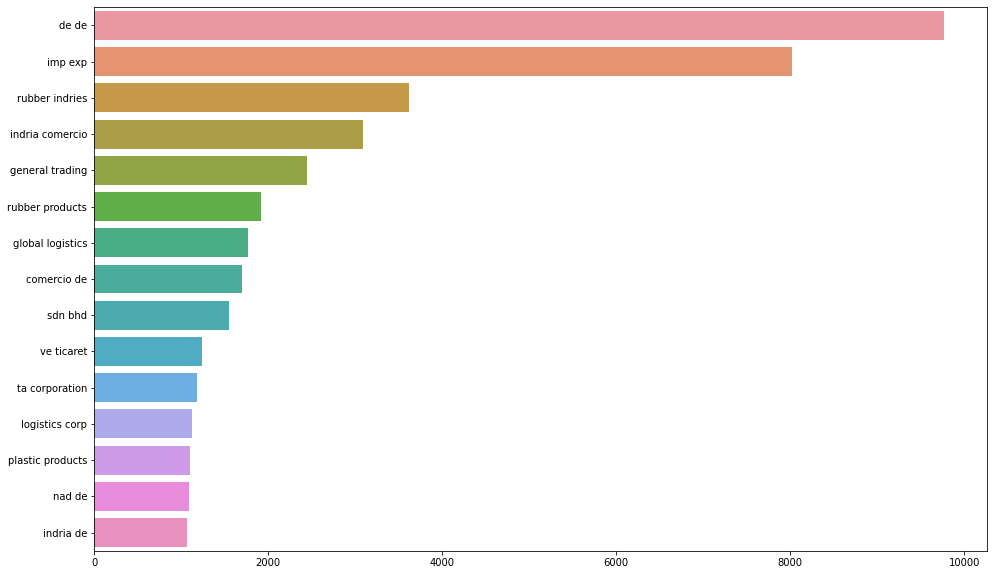

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq

top_n_bigrams = get_top_ngram(train['name_1'], 2)[:15]
# top_n_bigrams

x,y=map(list, zip(*top_n_bigrams))

plt.figure(figsize=(16,10))
sns.barplot(x=y, y=x)
plt.show()

In [22]:
uni_bigrams = list(set().union(get_top_ngram(train['name_2'], 1), get_top_ngram(train['name_1'], 1))) 

uni_bigrams_2s = [word[0] for word in uni_bigrams if len(word[0]) < 3]
uni_bigrams_3s = [word[0] for word in uni_bigrams if len(word[0]) < 4]

In [23]:
filter_ngrams = ['corporation', 'limited', 'city', 'corp', 'indria comercio', 'comercio', 'indria', 'indrial',
                 'imp', 'exp', 'a', 'e', 'de de', 'nad de', 've ticaret',
                 'de rl', 'rl de', 'sdn bhd', 'sp oo'] + uni_bigrams_2s + uni_bigrams_3s[:300]

In [24]:
%%time

for dataset in tqdm((train, test)):
    dataset.replace(multi_str_replace(filter_ngrams), '', inplace=True)

  0%|          | 0/2 [00:00<?, ?it/s]

\b(?:corporation|limited|city|corp|indria\ comercio|comercio|indria|indrial|imp|exp|a|e|de\ de|nad\ de|ve\ ticaret|de\ rl|rl\ de|sdn\ bhd|sp\ oo|pt|ps|c2|re|za|hr|id|or|ye|tk|sr|et|vu|az|fa|10|dd|fe|bm|s2|ll|nw|pa|ek|gw|gl|my|ji|ef|ek|ck|rt|hc|rk|ab|se|f3|wj|jv|vj|29|51|cd|mp|pv|ke|yn|mo|dw|ea|md|om|rg|c7|on|eu|do|cj|ru|td|pi|gb|en|ib|ez|be|ss|as|és|qu|bl|ru|so|va|mj|mk|th|be|vi|sn|ww|dh|br|ac|jo|db|fw|zf|hp|ti|ak|30|sb|ma|fu|c7|rs|rd|pu|wh|st|kc|qc|du|uy|fg|cr|mu|fc|ts|r1|25|rr|hr|qi|aa|gd|ke|hk|wo|cj|he|bh|vu|pm|ei|aş|ya|cs|ct|gt|in|cz|sg|ka|as|te|us|sx|hs|lt|cl|mn|ny|wu|wf|dm|18|km|js|lg|qi|wc|nk|ao|kr|ap|yn|mr|72|ri|ds|ed|tp|cz|jh|21|gu|al|ro|jp|27|li|bm|ka|p2|sj|vc|fr|np|nl|uk|q8|di|jb|ci|cs|ia|gz|mx|jx|mo|sk|ly|oz|ga|mb|ta|ae|cm|nv|is|ht|wv|na|az|lv|of|fe|jg|ng|ae|oh|vs|wf|jc|lt|cp|mr|w0|pe|oü|gl|ds|сп|tu|bg|tr|jd|gk|yf|m3|to|c2|ri|re|pp|pe|lm|vf|jw|gb|tw|sv|md|ws|on|cu|nb|fb|sv|tg|10|wl|jg|ak|sb|bh|nr|ai|ar|ck|me|ez|gv|li|sr|rj|60|st|jf|mp|ol|io|39|oo|dw|da|ni|ii|rg|rc|ep|nz|jo|

In [25]:
train[train.is_duplicate==1]

,name_1,name_2,is_duplicate
pair_id,,,
144,nippon oil gas exploration,nippon oil gas exploration technical services,1
560,pirelli neumaticos,pirelli tyre,1
774,brenntag,brenntag group,1
1230,paul bauder bochum plant,paul bauder,1
1445,total sro,total,1
...,...,...,...
458469,arlanxeo group,arlanxeo,1
458706,brenntag,brenntag comercial,1
458769,dow chemical,dow chemical,1


## EDA (Counts, Words, N-Grams)

             Frequency
Word                  
indries          14435
trading          12051
logistics        10958
rubber            8550
products          4839
chemical          3033
plastic           2748
enterprises       2688
chemicals         2577
group             2300


<AxesSubplot:xlabel='Word'>

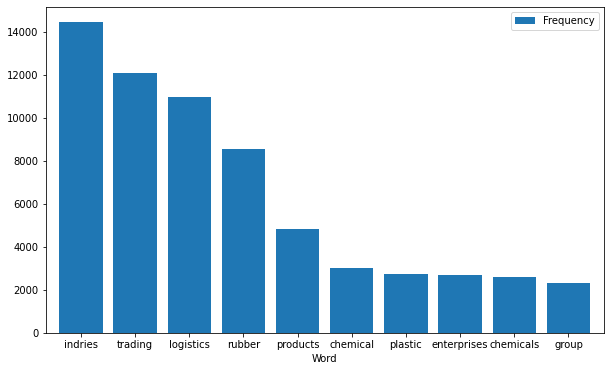

In [26]:
top_N = 10

stopwords = nltk.corpus.stopwords.words('english')

RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))

words = (test.name_1
           .str.lower()
           .replace([r'\|', RE_stopwords], [' ', ''], regex=True)
           .str.cat(sep=' ')
           .split()
)

# generate DF out of Counter
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
print(rslt)

# plot
rslt.plot.bar(rot=0, figsize=(10,6), width=0.8)

## Feature Engineering

In [27]:
from strsimpy.normalized_levenshtein import NormalizedLevenshtein
from strsimpy.damerau import Damerau
from strsimpy.ngram import NGram

#### 1. Normalized Levenshtein distance

In [28]:
normalized_levenshtein = NormalizedLevenshtein()

train['norm_levenstein'] = train.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                                axis=1)
test['norm_levenstein'] = test.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                              axis=1)

  0%|          | 0/459450 [00:00<?, ?it/s]

  0%|          | 0/213249 [00:00<?, ?it/s]

#### 2. Damerau-Levenshtein distance

In [29]:
damerau = Damerau()

train['damerau'] = train.progress_apply(lambda r: damerau.distance(r.name_1, r.name_2), axis=1)
test['damerau'] = test.progress_apply(lambda r: damerau.distance(r.name_1, r.name_2), axis=1)

  0%|          | 0/459450 [00:00<?, ?it/s]

  0%|          | 0/213249 [00:00<?, ?it/s]

#### 3. N-Grams (Two Grams)

In [30]:
twogram = NGram(2)

train['two_ngram'] = train.progress_apply(lambda r: twogram.distance(r.name_1, r.name_2), axis=1)
test['two_ngram'] = test.progress_apply(lambda r: twogram.distance(r.name_1, r.name_2), axis=1)

  0%|          | 0/459450 [00:00<?, ?it/s]

  0%|          | 0/213249 [00:00<?, ?it/s]

#### 4. Jaccard similarity index

In [31]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    
    try:
        jaccard = float(len(c)) / (len(a) + len(b) - len(c))
    except Exception:
        jaccard = 0
        
    return jaccard

train['jaccard'] = train.progress_apply(lambda r: get_jaccard_sim(r.name_1, r.name_2), axis=1)
test['jaccard'] = test.progress_apply(lambda r: get_jaccard_sim(r.name_1, r.name_2), axis=1)

  0%|          | 0/459450 [00:00<?, ?it/s]

  0%|          | 0/213249 [00:00<?, ?it/s]

#### 5. SequenceMatcher ratio

In [32]:
def seq_match(str1, str2):
    return CSequenceMatcher(None, str1, str2).ratio()

train['seq_match'] = train.progress_apply(lambda r: seq_match(r.name_1, r.name_2), axis=1)
test['seq_match'] = test.progress_apply(lambda r: seq_match(r.name_1, r.name_2), axis=1)

  0%|          | 0/459450 [00:00<?, ?it/s]

  0%|          | 0/213249 [00:00<?, ?it/s]

In [33]:
train[train.is_duplicate==1].head()

,name_1,name_2,is_duplicate,norm_levenstein,damerau,two_ngram,jaccard,seq_match
pair_id,,,,,,,,
144,nippon oil gas exploration,nippon oil gas exploration technical services,1,0.395833,19.0,0.395833,0.666667,0.753247
560,pirelli neumaticos,pirelli tyre,1,0.473684,9.0,0.500000,0.333333,0.606061
774,brenntag,brenntag group,1,0.357143,5.0,0.357143,0.500000,0.782609
1230,paul bauder bochum plant,paul bauder,1,0.571429,16.0,0.571429,0.500000,0.600000
1445,total sro,total,1,0.500000,5.0,0.500000,0.500000,0.666667


## EDA (Difference between Classes & Feature Generation)

#### Normalize Damerau

In [34]:
from sklearn import preprocessing

damerau_values = train[['damerau']]

scaler = preprocessing.MinMaxScaler()

damerau_scaled = scaler.fit_transform(damerau_values)

train['norm_damerau'] = damerau_scaled

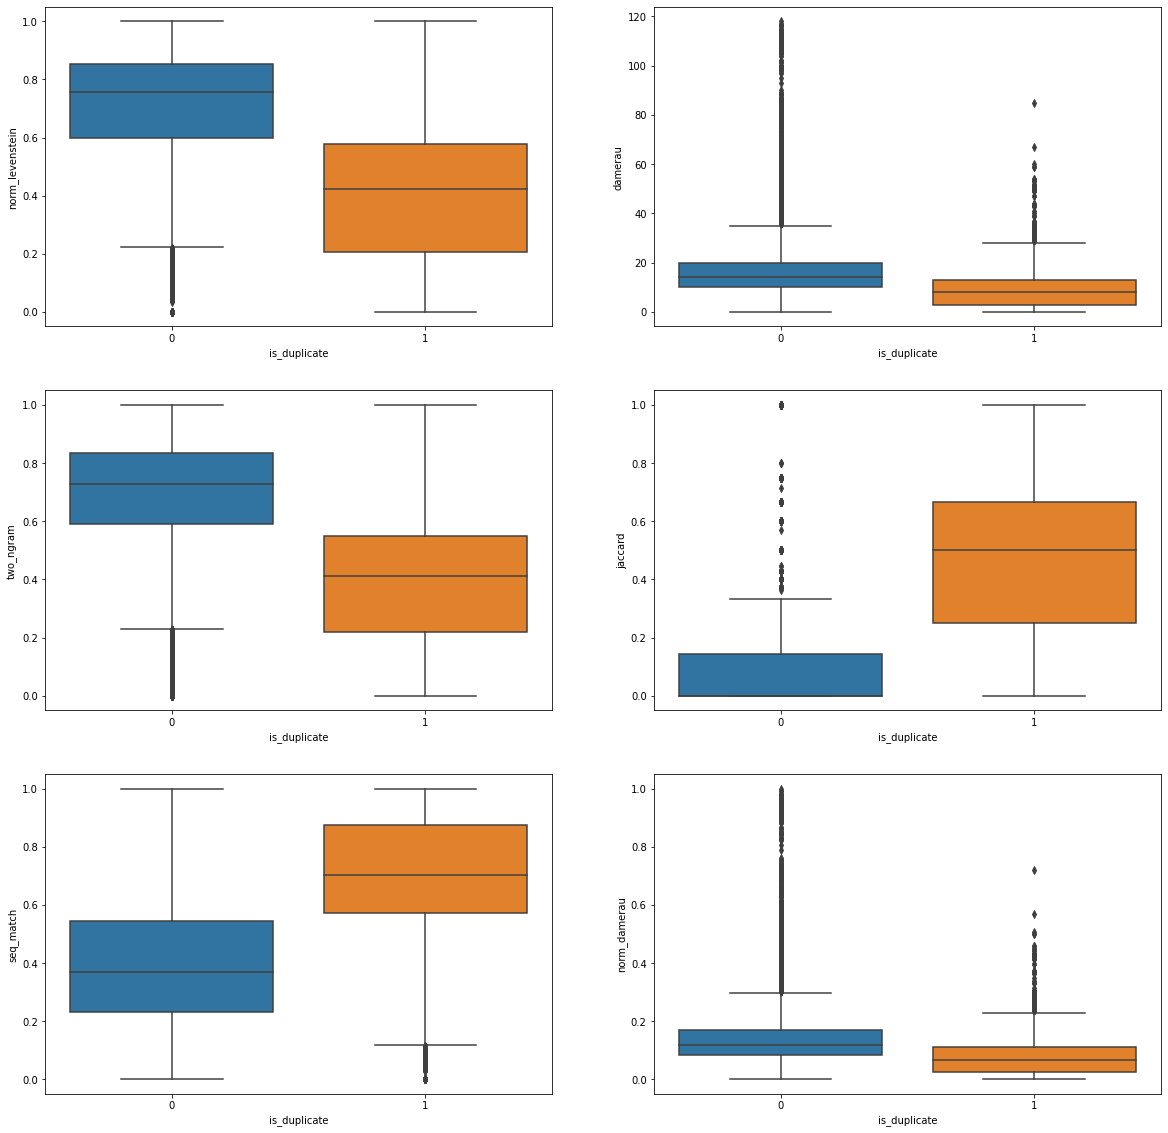

In [35]:
fig, axes = plt.subplots(3, 2, figsize=(20,20))

ax = sns.boxplot(x="is_duplicate", y="norm_levenstein", data=train, orient='v', ax=axes[0, 0])
ax = sns.boxplot(x="is_duplicate", y="damerau", data=train, orient='v', ax=axes[0, 1])
ax = sns.boxplot(x="is_duplicate", y="two_ngram", data=train, orient='v', ax=axes[1, 0])
ax = sns.boxplot(x="is_duplicate", y="jaccard", data=train, orient='v', ax=axes[1, 1])
ax = sns.boxplot(x="is_duplicate", y="seq_match", data=train, orient='v', ax=axes[2, 0])
ax = sns.boxplot(x="is_duplicate", y="norm_damerau", data=train, orient='v', ax=axes[2, 1])

From EDA could be infered that two classes are supposed to be separable, maybe additional features and feature engineering would moreover improve target score

## Balance Classes

Sample of code, to balance classes by downsampling majority class. But won't work in a real world problem. But still it may be possible to downsample garbage samples of 0 class, and to use data augmentation for the 1 class.

In [36]:
from sklearn.utils import resample

df_majority = train[train.is_duplicate==0]
df_minority = train[train.is_duplicate==1]

df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=3658,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.is_duplicate.value_counts()

1    3708
0    3658
Name: is_duplicate, dtype: int64

## Baseline Model

#### LogisticRegression

In [37]:
from sklearn.metrics import f1_score

In [38]:
features = ['norm_levenstein', 'damerau', 'two_ngram', 'jaccard', 'seq_match']
THR = 0.9

In [39]:
split = StratifiedShuffleSplit(1, train_size=0.8, random_state=0)
tridx, cvidx = list(split.split(train[features], train["is_duplicate"]))[0]

In [40]:
%%time

model = LogisticRegression(class_weight="balanced", random_state=0)
model.fit(train.iloc[tridx][features].values,
          train.iloc[tridx]["is_duplicate"].values)

CPU times: user 7.35 s, sys: 3.68 s, total: 11 s
Wall time: 3.4 s


LogisticRegression(class_weight='balanced', random_state=0)

In [41]:
%%time

tr_preds = model.predict_proba(train.iloc[tridx][features].values)
cv_preds = model.predict_proba(train.iloc[cvidx][features].values)

CPU times: user 277 ms, sys: 72.2 ms, total: 349 ms
Wall time: 175 ms


In [42]:
tr_preds = (tr_preds[:, 1] > THR).astype(np.int)
cv_preds = (cv_preds[:, 1] > THR).astype(np.int)

In [43]:
print(f1_score(train.iloc[tridx]["is_duplicate"].values, tr_preds))
print(f1_score(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

0.2787210982658959
0.29353932584269665


In [44]:
print(classification_report(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     91148
           1       0.20      0.56      0.29       742

    accuracy                           0.98     91890
   macro avg       0.60      0.77      0.64     91890
weighted avg       0.99      0.98      0.98     91890



#### Random Forest

In [45]:
%%time

from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=100, random_state=0)

clf_rf.fit(train.iloc[tridx][features].values,
          train.iloc[tridx]["is_duplicate"].values)

tr_preds = clf_rf.predict_proba(train.iloc[tridx][features].values)
cv_preds = clf_rf.predict_proba(train.iloc[cvidx][features].values)

tr_preds = (tr_preds[:, 1] > THR).astype(np.int)
cv_preds = (cv_preds[:, 1] > THR).astype(np.int)

CPU times: user 59.2 s, sys: 31.4 ms, total: 59.3 s
Wall time: 59.4 s


In [46]:
print(f1_score(train.iloc[tridx]["is_duplicate"].values, tr_preds))
print(f1_score(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

0.435836627140975
0.31096196868008946


In [47]:
print(classification_report(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     91148
           1       0.91      0.19      0.31       742

    accuracy                           0.99     91890
   macro avg       0.95      0.59      0.65     91890
weighted avg       0.99      0.99      0.99     91890



#### XGBoost Classifier

In [48]:
%%time

from xgboost import XGBClassifier

clf_xgb = XGBClassifier(random_state=0)

clf_xgb.fit(train.iloc[tridx][features].values,
          train.iloc[tridx]["is_duplicate"].values)

tr_preds = clf_xgb.predict(train.iloc[tridx][features].values)
cv_preds = clf_xgb.predict(train.iloc[cvidx][features].values)

CPU times: user 47.8 s, sys: 171 ms, total: 48 s
Wall time: 16.2 s


In [49]:
print(f1_score(train.iloc[tridx]["is_duplicate"].values, tr_preds))
print(f1_score(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

0.6396490495090871
0.5585429314830876


In [50]:
print(classification_report(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     91148
           1       0.78      0.43      0.56       742

    accuracy                           0.99     91890
   macro avg       0.89      0.72      0.78     91890
weighted avg       0.99      0.99      0.99     91890



#### LigtGBM Classifier

In [51]:
%%time

from lightgbm import LGBMClassifier

clf_lgbm = LGBMClassifier(random_state=0)

clf_lgbm.fit(train.iloc[tridx][features].values,
          train.iloc[tridx]["is_duplicate"].values)

tr_preds = clf_lgbm.predict(train.iloc[tridx][features].values)
cv_preds = clf_lgbm.predict(train.iloc[cvidx][features].values)

CPU times: user 9.84 s, sys: 67.4 ms, total: 9.91 s
Wall time: 3.71 s


In [52]:
print(f1_score(train.iloc[tridx]["is_duplicate"].values, tr_preds))
print(f1_score(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

0.49452201933404943
0.42132416165090286


In [53]:
print(classification_report(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     91148
           1       0.58      0.33      0.42       742

    accuracy                           0.99     91890
   macro avg       0.79      0.66      0.71     91890
weighted avg       0.99      0.99      0.99     91890



After a bunch of models comparaison, XGBoost was determined to be best base model for hyperparameter tuning and improving baseline Logistic Regression solution

## Models

### XGBoost Classifier GridSearch Model (Hyperparameter tuning)

XGBoost score and parameters could be improved by Grid Search and Cross Validation, but it is a costly operation due to large train size

In [54]:
%%time

from sklearn.model_selection import GridSearchCV

clf = XGBClassifier(scale_pos_weight=1, random_state=0, n_estimators=250, max_depth=9, subsample=0.85, reg_lambda=1,
                   learning_rate=0.1)

grid = {'learning_rate': [0.001, 0.005, 0.01, 0.03, 0.05, 0.1]}

grid_clf = GridSearchCV(clf, grid, 
                    verbose=True, 
                    scoring='f1', cv=3, n_jobs=4)

grid_clf.fit(train.iloc[tridx][features].values,
          train.iloc[tridx]["is_duplicate"].values)

grid_clf.best_score_, grid_clf.best_params_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed: 12.5min finished


CPU times: user 3min 14s, sys: 855 ms, total: 3min 15s
Wall time: 13min 30s


(0.5862661510280366, {'learning_rate': 0.1})

In [55]:
%%time

clf = XGBClassifier(scale_pos_weight=1, n_estimators=250, max_depth=9, subsample=0.85, reg_lambda=1,
                   learning_rate=0.1)

clf.fit(train.iloc[tridx][features].values,
          train.iloc[tridx]["is_duplicate"].values)

tr_preds = clf.predict(train.iloc[tridx][features].values)
cv_preds = clf.predict(train.iloc[cvidx][features].values)

CPU times: user 3min 11s, sys: 359 ms, total: 3min 12s
Wall time: 51.8 s


In [56]:
print(f1_score(train.iloc[tridx]["is_duplicate"].values, tr_preds))
print(f1_score(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

0.744429374152296
0.6185397867104185


In [57]:
print(classification_report(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     91148
           1       0.79      0.51      0.62       742

    accuracy                           0.99     91890
   macro avg       0.89      0.75      0.81     91890
weighted avg       0.99      0.99      0.99     91890



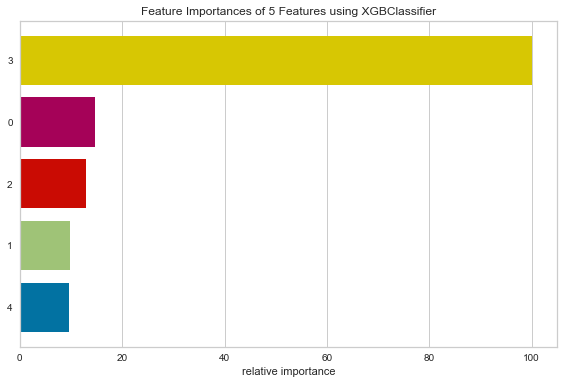

In [58]:
from yellowbrick.model_selection import FeatureImportances

viz = FeatureImportances(clf)
viz.fit(train.iloc[tridx][features].values,
          train.iloc[tridx]["is_duplicate"].values)
viz.show()
plt.show()

In [59]:
train[features].corr()

,norm_levenstein,damerau,two_ngram,jaccard,seq_match
norm_levenstein,1.000000,0.534430,0.506050,-0.688763,-0.946747
damerau,0.534430,1.000000,0.253308,-0.298672,-0.530814
two_ngram,0.506050,0.253308,1.000000,-0.444227,-0.440870
jaccard,-0.688763,-0.298672,-0.444227,1.000000,0.668412
seq_match,-0.946747,-0.530814,-0.440870,0.668412,1.000000


<AxesSubplot:>

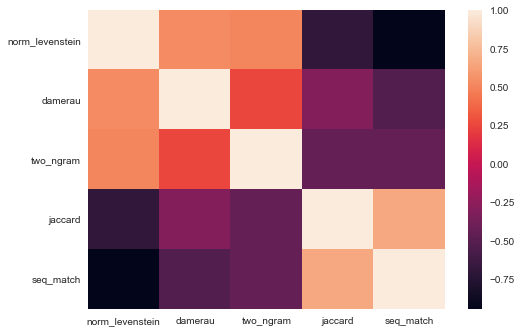

In [60]:
sns.heatmap(train[features].corr())

Linear models are susceptible for **multicollinearity** ( (almost) linear dependant features), but Ensemble models on Decision Trees work well without eradicating multicollinearity

## Submission

In [62]:
sample_sub = pd.read_csv('data/sample_submission.csv', index_col='pair_id')
sample_sub.head()

,is_duplicate
pair_id,
1,1
2,1
3,1
4,1
5,1


In [63]:
sample_sub['is_duplicate'] = clf.predict(test[features].values).astype(np.int)

In [64]:
sample_sub.to_csv('submission.csv')

In [65]:
my_submission = pd.read_csv('submission.csv', index_col='pair_id')
my_submission.head()

,is_duplicate
pair_id,
1,0
2,0
3,0
4,0
5,0


In [66]:
my_submission.is_duplicate.value_counts()

0    212727
1       522
Name: is_duplicate, dtype: int64

XGBoost submission has found **522 instances of class 1** on test dataset, which correspond to **~ 0.35 score (F1)** on public leaderboard